In [9]:
import numpy as np

# generate data

In [10]:
# In real world, you cannot learn how the data was generated. So do not rely on this function when coding your lab.

# In order to make the DEBUG more easy, I add the random seed for option 
def generate_data(dim = 10, num = 100, random_seed = -1):
    if random_seed != -1:
        np.random.seed(random_seed)
    x = np.random.normal(0, 10, [num, dim])

    if random_seed != -1:
        np.random.seed(random_seed)
    coef = np.random.uniform(-1, 1, [dim, 1])

    pred = np.dot(x, coef)
    pred_n = (pred - np.mean(pred)) / np.sqrt(np.var(pred))
    label = np.sign(pred_n)

    if random_seed != -1:
        np.random.seed(random_seed)
    mislabel_value = np.random.uniform(0, 1, num)
    mislabel = 0

    for i in range(num):
        if np.abs(pred_n[i]) < 1 and mislabel_value[i] > 0.9 + 0.1 * np.abs(pred_n[i]):
            label[i] *= -1
            mislabel += 1
    return x, label, mislabel/num

In [11]:
# example
x, y, mr = generate_data(5, 100)
print(x[1:10])
print(y[1:10])
print(mr)
print(type(x))




[[  0.65475098  17.43771375  23.7979031    2.31929224   4.01967272]
 [  0.65063315  -3.90673124  -3.30279963   8.12369148   5.7409164 ]
 [ 13.49677549  -7.28268599   3.45515662  -7.31953489  -8.3915507 ]
 [ 18.24815596   3.58816688   6.24502666  -8.60850767   2.20870704]
 [-14.30777315   8.40944468 -12.69463475 -17.06358572   0.29099073]
 [ -3.36474524  16.48274447   1.43433862   4.54736101   4.34390989]
 [ 15.68913803   1.32421562   1.22486421 -19.00344827   6.08027796]
 [  8.44849277  -7.38994918  13.23943508   9.8807742  -10.82450721]
 [  2.10691723   4.53677386  -7.54328332  -1.72299162   7.86980328]]
[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]]
0.04
<class 'numpy.ndarray'>


# write your model class

In [12]:
# you can do anything necessary about the model
def my_max(a, b):
    return a if a > b else b

def find_zero(a, b):
    return 0 if a == 0 else b

def array_max(a:np.ndarray, b:np.ndarray)->np.ndarray:
    func_ = np.frompyfunc(my_max, 2, 1)
    return(func_(a, b))

def array_find0(a:np.ndarray, b:np.ndarray) -> np.ndarray:
    func_ = np.frompyfunc(find_zero, 2, 1)
    return(func_(a, b))

class SVM1:
    def __init__(self, dim, random_seed = -1):
        """
        You can add some other parameters, which I think is not necessary
        """
        self.dim = dim
        self.random_seed = abs(random_seed) if random_seed != -1 else -1

    def fit(self, X:np.ndarray, y:np.ndarray, gamma = 0.001, lr = 0.01, tol=1e-3, max_times = 1000):
        """
        ---
        parameters:
        ---
            X: Data characteristics
            y: Data category
            gamma: Loss function parameter. Default 0.1
            lr: Learning rate. Default 0.1
            max_times: The maximum times of training iterations. Default 1000
            tol: 梯度下降的阈值 Defalut 1e-5
        """
        m, n = X.shape

        if self.random_seed != -1:
            np.random.seed(self.random_seed)
        # self.w = np.random.uniform(low = 0.0, high = 1.0, size = n + 1).reshape(-1, 1)
        self.w = np.zeros((n + 1, 1))

        temp_1 = np.ones((m, 1))
        X_hat:np.ndarray = np.c_[X, temp_1]

        temp_0 = np.zeros((m, 1))
        alpha = np.zeros((m, 1))
        loss_list = []
        y_diag = np.diag(y.reshape(-1))

        
        for times in range(max_times):
            xi = array_max(temp_0, 1 - y_diag @ X_hat @ self.w)
            loss = 0.5 * self.w.T @ self.w + (gamma * xi).sum()
            loss_list.append(loss[0][0])

            y_bar = array_find0(xi , y)

            delta_1 = self.w + gamma * (- X_hat.T @ y_bar)
            
            if times >= 2 and delta_1.T @ delta_1 < tol:
                break

            self.w = self.w - lr * delta_1

        return loss_list, times
            


        
    def predict(self, X:np.ndarray):
        """
        Use the trained model to generate prediction probabilities on a new
        collection of data points.
        """

        m, n = X.shape
        temp_1 = np.ones(m)
        X_hat:np.ndarray = np.c_[X, temp_1]

        temp = X_hat @ self.w
        ans = []
        for i in range(m):
            if temp[i] > 0:
                ans.append(1)
            else:
                ans.append(-1)
        
        return np.array(ans).reshape(-1, 1)

In [13]:
# you can do anything necessary about the model
class SVM2:
    def __init__(self, dim):
        """
        You can add some other parameters, which I think is not necessary
        """

    def fit(self, X:np.ndarray, y:np.ndarray):
        """
        Fit the coefficients via your methods
        """
        
    def predict(self, X:np.ndarray):
        """
        Use the trained model to generate prediction probabilities on a new
        collection of data points.
        """

# construct and train your models

d:\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


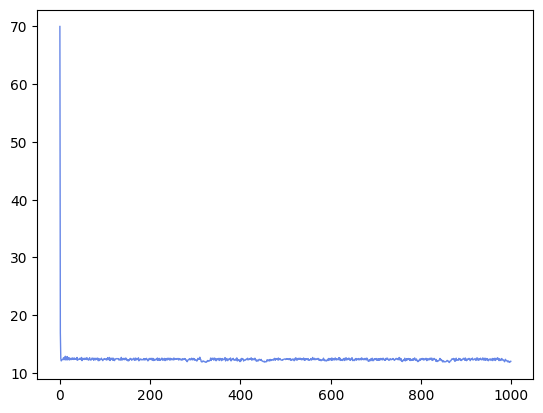

In [14]:
# generate data
X_data, y_data, mislabel = generate_data(dim=20, num=1000) 

# split data
def random_Split_data(X: np.ndarray, y:np.ndarray, rate = 0.7, random_seed: int = -1):
    data: np.ndarray = np.hstack((X, y))
    m, n = data.shape
    if random_seed != -1:
        np.random.seed(abs(random_seed))
    np.random.shuffle(data)
    
    row_split = int(m * rate)
    X_train = data[0: row_split, 0: -1]
    y_train = data[0: row_split, -1: ]
    X_test = data[row_split: m, 0: -1]
    y_test = data[row_split: m, -1: ]
    
    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = random_Split_data(X_data, y_data, rate=0.7)


# constrcut model and train (remember record time)
model1 = SVM1(dim = 2) 
loss_list, times = model1.fit(X_train, y_train, gamma = 0.1, lr = 0.001, tol=1e-3)
# print(model1.w)

# print(times)
# print(loss_list)

import matplotlib.pyplot as plt
from sklearn import svm
model_skl = svm.SVC(kernel='linear')
model_skl.fit(X_train, y_train)



def show(times, loss, color = '#4169E1', start=0, end=1500):
    x_axis_data = list(range(times + 1))[start:end]
    y_axis_data = loss[start:end]
    plt.plot(x_axis_data, y_axis_data, color=color, alpha=0.8, linewidth=1)


show(times, loss_list, end=10000)


# predict and compare your results

In [15]:
# make prediction

def model_cmp(y_pre:np.ndarray, y_test:np.ndarray):
    # y should be in shape m x 1
    corr = 0
    sum = 0
    m, n = y_pre.shape
    
    for i in range(m):
        if y_pre[i] == y_test[i]:
            corr += 1
        sum += 1
    return corr/sum

# pred = model1.predict()

# compared with answer

# compare each methods
# print(X_test.shape)
pre = model1.predict(X_test)
print(pre.shape)
print(model_cmp(pre, y_test))
# print(model_skl.predict(X_test))

print(model_cmp(model_skl.predict(X_test).reshape(-1, 1), y_test))

(300, 1)
0.94
0.9366666666666666


In [16]:
# Calculate the model accuracy on average

import sklearn


def model_accuracy_ave(model:str = '1', dim = 10, num = 1000, devide_rate = 0.7, total_time = 20):   # all possible parameters

    model_list = ['1', '2', 'skl']
    assert model in model_list, "unknown model: {}".format(model)

    sum = 0

    if model == '1':
        for _ in range(total_time):
            X_data, y_data, mislabel = generate_data(dim, num) 
            X_train, y_train, X_test, y_test = random_Split_data(X_data, y_data, devide_rate)

            model = SVM1(dim) 
            model.fit(X_train, y_train)
            pred = model.predict(X_test)

            sum = sum + model_cmp(pred, y_test)
            print(model_cmp(pred, y_test))

    elif model == '2':
        for _ in range(total_time):
            X_data, y_data, mislabel = generate_data(dim, num) 
            X_train, y_train, X_test, y_test = random_Split_data(X_data, y_data, devide_rate)

            model = SVM2(dim) 
            model.fit(X_train, y_train)
            pred = model.predict(X_test)

            sum += model_cmp(pred, y_test)

    elif model == 'skl':
        for _ in range(total_time):
            X_data, y_data, mislabel = generate_data(dim, num) 
            X_train, y_train, X_test, y_test = random_Split_data(X_data, y_data, devide_rate)

            model = svm.SVC(kernel='linear')
            model.fit(X_train, y_train)
            pred = model.predict(X_test).reshape(-1, 1)

            sum += model_cmp(pred, y_test)
            print(model_cmp(pred, y_test))



    return sum/total_time

print("Model_{}:Ave={}".format('1', model_accuracy_ave(model='1')))
print("Model_{}:Ave={}".format('skl', model_accuracy_ave(model='1')))

0.95
0.94
0.9266666666666666
0.9566666666666667
0.94
0.9433333333333334
0.9466666666666667
0.9466666666666667
0.93
0.9466666666666667
0.9433333333333334
0.9433333333333334
0.92
0.9466666666666667
0.93
0.93
0.95
0.9466666666666667
0.9566666666666667
0.9566666666666667
Model_1:Ave=0.9424999999999999
0.96
0.95
0.9333333333333333
0.9266666666666666
0.9533333333333334
0.9533333333333334
0.9366666666666666
0.9333333333333333
0.9533333333333334
0.9266666666666666
0.94
0.9566666666666667
0.9533333333333334
0.9566666666666667
0.9333333333333333
0.93
0.9566666666666667
0.94
0.9533333333333334
0.9466666666666667
Model_skl:Ave=0.9446666666666665
